In [48]:
# Step 1: Define Functions
import ssh

EMA_HOST = "169.254.9.108"
OCPI_CDK_DIR = "/run/media/mmcblk0p2/opencpi"
OCPI_LOCAL_DIR = OCPI_CDK_DIR
OCPI_ROOT_DIR = OCPI_CDK_DIR + "/.."
OCPI_LIBRARY_PATH = OCPI_CDK_DIR + "/ema_lb_rcc/artifacts:" + OCPI_CDK_DIR + "/artifacts"
OCPI_SYSTEM_CONFIG = OCPI_CDK_DIR + "/system.xml"
OCPI_TOOL_PLATFORM = "ema_lb_rcc"
OCPI_DEFAULT_HDL_DEVICE = "pl:0"
OCPI_TOOL_DIR = OCPI_TOOL_PLATFORM
OCPI_TOOL_OS = "linux"
OCPI_RELEASE = "opencpi-v2.3.0"
APP_ROOT = "/run/media/nvme0n1/opencpi"
APP_REL_DIR = "applications/ocpi_xcvrtool"
APP_PATH = "target-ema_lb_rcc/ocpi_xcvrtool"

passwords = {}
s = ssh.SSH(EMA_HOST, passwords)

ENVIRONMENT = "export OCPI_CDK_DIR=" + OCPI_CDK_DIR
ENVIRONMENT += ";export OCPI_LOCAL_DIR=" + OCPI_LOCAL_DIR
ENVIRONMENT += ";export OCPI_ROOT_DIR=" + OCPI_ROOT_DIR
ENVIRONMENT += ";export OCPI_LIBRARY_PATH=" + OCPI_LIBRARY_PATH
ENVIRONMENT += ";export OCPI_SYSTEM_CONFIG=" + OCPI_SYSTEM_CONFIG
ENVIRONMENT += ";export OCPI_TOOL_PLATFORM=" + OCPI_TOOL_PLATFORM
ENVIRONMENT += ";export OCPI_DEFAULT_HDL_DEVICE=" + OCPI_DEFAULT_HDL_DEVICE
ENVIRONMENT += ";export OCPI_TOOL_DIR=" + OCPI_TOOL_DIR
ENVIRONMENT += ";export OCPI_TOOL_OS=" + OCPI_TOOL_OS
ENVIRONMENT += ";export OCPI_RELEASE=" + OCPI_RELEASE

def preinitialise():
    s.send_command("/bin/echo {}/{} > /tmp/ocpi_app_directory".format(APP_ROOT, APP_REL_DIR))
    s.send_command("cd {};. ./kcema_setup.sh {}".format(OCPI_CDK_DIR, "/tmp")) # Load OpenCPI bitstream
    s.send_command("/sbin/devmem 0x40014000 32 0x00") # Disable all PSUs
    s.send_command("/sbin/devmem 0x40014000 32 0xFF") # Enable all PSUs
    s.send_command("/sbin/devmem 0x40015008 32 0x01") # Enable clock generator
    s.send_command("cd /run/media/mmcblk0p2/test;/usr/bin/python3 ad9528.py") # Initialise clock generator
    initialise(6000, False)
    
def initialise(centre_freq_MHz, lna_en):
    lna = 0
    if lna_en:
        lna = 1
    s.send_command("{};cd {}/{};./{} -F {} -L {} -T 0".format(ENVIRONMENT, OCPI_CDK_DIR, APP_REL_DIR, APP_PATH, str(centre_freq_MHz), lna))

def capture(capture_size, filename):    
    s.send_command("/bin/rm /run/media/nvme0n1/{}".format(filename))
    s.send_command("/usr/bin/fallocate /run/media/nvme0n1/{} -l {}".format(filename, capture_size))
    s.send_command("/bin/echo 1 > /sys/kernel/kcema-driver/reset")
    s.send_command("/bin/echo 0 > /sys/kernel/kcema-driver/reset")
    s.send_command("/bin/echo /run/media/nvme0n1/{} > /sys/kernel/kcema-driver/write_path".format(filename))
    s.send_command("/bin/echo 1 > /sys/kernel/kcema-driver/write_state")

def transmit(filename):
    s.send_command("/bin/echo 1 > /sys/kernel/kcema-driver/reset")
    s.send_command("/bin/echo 0 > /sys/kernel/kcema-driver/reset")
    s.send_command("/bin/echo /run/media/nvme0n1/{} > /sys/kernel/kcema-driver/read_path".format(filename))
    s.send_command("/bin/echo 1 > /sys/kernel/kcema-driver/read_state")

Connected to 169.254.9.108


In [3]:
# Step 2a: OpenCPI Initialisation
preinitialise()

Running login script.
OCPI_CDK_DIR is now /run/media/mmcblk0p2/opencpi
OCPI_ROOT_DIR is now /run/media/mmcblk0p2/opencpi/..
Executing /etc/profile.d/opencpi-persist.sh.
No reserved DMA memory found on the linux boot command line.
Driver loaded successfully.
OpenCPI ready for zynq.
Loading bitstream
Loading local.kcema_ocpi_applications.nvme_iq_stream_ema_mbehb_hdl_cfg_trx_cnt_nvme_iq_stream_ema_bsp_mbehb.hdl.0.ema_mbehb_hdl.bitz
Bitstream loaded successfully
Discovering available containers...
Available containers:
 #  Model Platform            OS     OS-Version  Arch     Name
 0  hdl   ema_mbehb_hdl                                   PL:0
 1  rcc   ema_lb_rcc          linux  x17_3       aarch32  rcc0
AD9528 tests:
Check Vendor ID: OK
Initialise: OK
Status 0: 0xf2
Status 1: 0x08


OCPI( 1: 23.0449): drc: Transceiver initialised


dig_radio_ctrlr config lock request has been made
Initialise transceiver...
CLKPLL Status Check...
Synchronise JESD204B...
Verify synchronisation...
Load Binaries...
Load stream Binary...
Load ARM binary...
ARM initialisation...
Initial calibration...
Enable JESD204B Framer...
Send SysRef...
dig_radio_ctrlr config lock request was SUCCESSFUL
Application finished successfully


In [182]:
# Step 2b: Transceiver Initialisation
CENTRE_FREQ_MHZ = 3000  # Set this: EMA captures fc ±50 MHz
LNA_EN = False
initialise(CENTRE_FREQ_MHZ, LNA_EN)

OCPI( 1:581.0337): drc: Transceiver initialised


dig_radio_ctrlr config lock request has been made
Initialise transceiver...
CLKPLL Status Check...
Synchronise JESD204B...
Verify synchronisation...
Load Binaries...
Load stream Binary...
Load ARM binary...
ARM initialisation...
Initial calibration...
Enable JESD204B Framer...
Send SysRef...
dig_radio_ctrlr config lock request was SUCCESSFUL
Application finished successfully


In [94]:
# Step 3: Capture I/Q File to EMA SSD
import time
from datetime import datetime

#capture_size = "262144"  # Size of captured file in bytes (64K samples * 2 bytes per sample * 2 [I/Q])
CAPTURE_SIZE = "1M"
CAPTURE_FILENAME = "capture.iq"
capture(CAPTURE_SIZE, CAPTURE_FILENAME)
time.sleep(3)

In [189]:
# Step 3b: Transmit I/Q File
#TX_FILENAME = "cw-1000000.0_fs-122880000_amp-0dB_dur-4.096.iq"
TX_FILENAME = "cw-1228800.0_fs-122880000_amp-0dB_dur-5.120.iq"
transmit(TX_FILENAME)

In [95]:
# Step 4: Transfer I/Q File to PC
print("Transferring to host PC: {}".format(CAPTURE_FILENAME))
s.get_file("/run/media/nvme0n1/{}".format(CAPTURE_FILENAME), CAPTURE_FILENAME)

Transferring to host PC: capture.iq


1252.0
1252.0
[  377.+1191.j  -833. +934.j -1229. -241.j  -419.-1177.j   800. -963.j
  1234. +198.j   458.+1163.j  -767. +988.j -1242. -157.j  -499.-1147.j]


c:\Users\rharrison\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


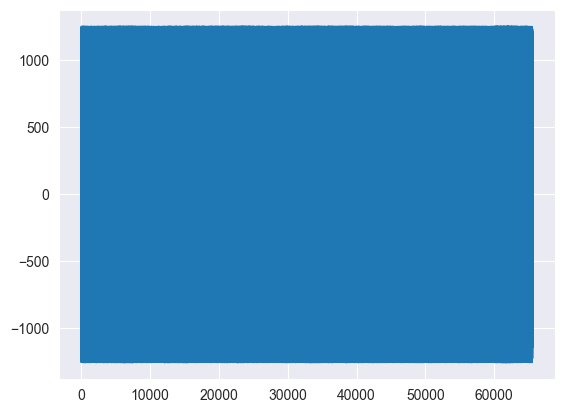

In [99]:
# Step 5: Read Samples, Plot Spectrogram
import numpy as np
from numpy.fft import fft, fftshift, fftfreq
import seaborn as sns
import matplotlib.pyplot as plt

CENTRE_FREQ_HZ = CENTRE_FREQ_MHZ * 1e6
FFT_SIZE = 65536
SAMPLE_RATE_SPS = 122.88e6
FILE_OFFSET = 65536 * 4  # Skip 64K samples (2-bytes each, I+Q)

samples = np.fromfile(CAPTURE_FILENAME, dtype=np.int16, count=FFT_SIZE*2, offset=FILE_OFFSET)

if CENTRE_FREQ_MHZ <= 5900:
    # Not the LO path, no frequency inversion
    iq = (samples[::2] + 1j*samples[1::2])  # convert to IQIQIQ...
else:
    # LO path, frequency inversion, swap I/Q
    iq = (samples[1::2] + 1j*samples[::2])  # convert to QIQIQI...

print(np.max(np.real(iq)))
print(np.max(np.imag(iq)))
print(iq[0:10])
plt.plot(iq)

#plt.specgram(iq, Fs=SAMPLE_RATE_SPS, Fc=CENTRE_FREQ_HZ, scale="dB")#, vmin=-210, vmax=-100)
#plt.colorbar()

Marker: 3020.26 MHz, -5.39 dBm


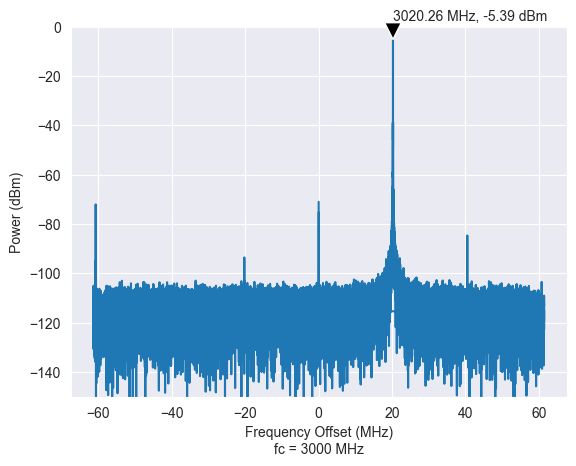

In [130]:
# Step 6: Plot FFT
f=fft(iq*np.blackman(FFT_SIZE))
x=fftfreq(FFT_SIZE) * SAMPLE_RATE_SPS / 1e6
offset_dB = 156
if LNA_EN:
    offset_dB += 21
spec=20*np.log10(np.abs(f))-offset_dB

sns.set_style('darkgrid')
fig, ax = plt.subplots()
ax.plot(x, spec)
ax.grid(True)
ax.set_xlabel("Frequency Offset (MHz)\nfc = {} MHz".format(CENTRE_FREQ_MHZ))
ax.set_ylabel("Power (dBm)")
ax.set_ylim(-150, 0)
ymax = max(spec)
xpos = np.where(spec == ymax)
xmax = x[xpos]
ax.annotate("{:.2f} MHz, {:.2f} dBm".format(float((CENTRE_FREQ_MHZ)+xmax), ymax), xy=(xmax, ymax), xytext=(xmax, ymax+8), arrowprops=dict(facecolor='black', shrink=0.05))
print("Marker: {:.2f} MHz, {:.2f} dBm".format(float((CENTRE_FREQ_MHZ)+xmax), ymax))
plt.savefig('fft.png')
plt.show()